In [1]:
from google.colab import files
uploaded = files.upload()
import os

zip_name = "archive.zip"
!unzip -q "$zip_name" -d /content

print("Content after unzip:", os.listdir("/content"))
TRAIN_DIR = "/content/train"
VAL_DIR   = "/content/test"

import os
print("Train exists:", os.path.exists(TRAIN_DIR))
print("Val exists:", os.path.exists(VAL_DIR))
print("Train classes:", os.listdir(TRAIN_DIR))


Saving archive.zip to archive.zip
Content after unzip: ['.config', 'train', 'test', 'archive.zip', 'sample_data']
Train exists: True
Val exists: True
Train classes: ['fear', 'disgust', 'angry', 'neutral', 'happy', 'surprise', 'sad']


In [3]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(48,48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(48,48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False
)

num_classes = train_generator.num_classes
print("class_indices:", train_generator.class_indices)

emotion_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

emotion_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

history = emotion_model.fit(
    train_generator,
    epochs=10,                 # 先跑10确认没问题，再改50
    validation_data=val_generator
)

emotion_model.save_weights("/content/emotion_model.weights.h5")
print("saved to /content/emotion_model.weights.h5")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
class_indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 427s 947ms/step - accuracy: 0.2538 - loss: 1.8243 - val_accuracy: 0.3553 - val_loss: 1.6885
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 445s 954ms/step - accuracy: 0.3521 - loss: 1.6554 - val_accuracy: 0.4081 - val_loss: 1.5412
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 437s 974ms/step - accuracy: 0.4053 - loss: 1.5502 - val_accuracy: 0.4381 - val_loss: 1.4576
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 432s 962ms/step - accuracy: 0.4339 - loss: 1.4677 - val_accuracy: 0.4692 - val_loss: 1.3980
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 435s 969ms/step - accuracy: 0.4673 - loss: 1.4070 - val_accuracy: 0.4852 - val_loss: 1.3485
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 422s 940ms/step - accuracy: 0.4915 - loss: 1.3582 - val_accuracy: 0.5031 - val_loss: 1.3099
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 424s 944ms/step - accuracy: 0.5039 - loss: 1.3073 - val_accuracy: 0.5099 - val_loss: 1.2789
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 424s 945ms/step - accuracy: 0.5200 - loss: 1.27

In [4]:
from google.colab import files
uploaded = files.upload()   # 上传 emojis.zip

zip_name = list(uploaded.keys())[0]
!unzip -q "$zip_name" -d /content

EMOJI_DIR = "/content/emojis"
import os
print("EMOJI_DIR exists:", os.path.exists(EMOJI_DIR))
print("Emoji files:", os.listdir(EMOJI_DIR)[:20])


Saving emojis.zip to emojis.zip
EMOJI_DIR exists: True
Emoji files: ['surprise.png', 'fear.png', 'neutral.png', 'sad.png', 'angry.png', 'disgust.png', 'happy.png']


In [6]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ✅ 用训练集的 class_indices 来对齐标签（最稳）
# 如果你刚刚训练过，train_generator 应该还在
idx_to_label = {v:k for k,v in train_generator.class_indices.items()}
print("idx_to_label:", idx_to_label)

# ✅ emoji 映射：标签名 -> 文件名（按你数据集小写类别）
emoji_map = {
    "angry": "angry.png",
    "disgust": "disgust.png",
    "fear": "fear.png",
    "happy": "happy.png",
    "neutral": "neutral.png",
    "sad": "sad.png",
    "surprise": "surprise.png"
}

# ✅ Haar cascade（不硬编码路径）
cascade_path = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_default.xml")
face_cascade = cv2.CascadeClassifier(cascade_path)

def preprocess_face_gray(face_gray_2d):
    """把灰度脸裁剪变成模型输入 (1,48,48,1)"""
    face = cv2.resize(face_gray_2d, (48,48))
    face = face.astype("float32") / 255.0
    face = np.expand_dims(face, axis=-1)  # (48,48,1)
    face = np.expand_dims(face, axis=0)   # (1,48,48,1)
    return face

def predict_emotion_and_show_emoji(image_path, assume_already_face=False):
    """
    assume_already_face:
      - True: 把整张图当作脸（适用于 FER2013 这种已经是人脸裁剪好的）
      - False: 先做人脸检测（适用于普通照片）
    """
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise ValueError("Cannot read image: " + image_path)

    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    if assume_already_face:
        # 直接用整图作为输入
        face_input = preprocess_face_gray(gray)
        show_rgb = rgb
        face_box = None
    else:
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        if len(faces) == 0:
            print("No face detected. Try assume_already_face=True.")
            plt.figure(figsize=(5,5))
            plt.imshow(rgb); plt.axis("off")
            plt.show()
            return

        # 取最大脸
        x,y,w,h = max(faces, key=lambda t: t[2]*t[3])
        face_roi = gray[y:y+h, x:x+w]
        face_input = preprocess_face_gray(face_roi)

        show_rgb = rgb.copy()
        cv2.rectangle(show_rgb, (x,y), (x+w,y+h), (255,0,0), 2)
        face_box = (x,y,w,h)

    # 预测
    pred = emotion_model.predict(face_input, verbose=0)[0]
    idx = int(np.argmax(pred))
    label = idx_to_label.get(idx, str(idx))
    conf = float(np.max(pred))

    print(f"Predicted: {label}  (confidence={conf:.3f})")
    # 显示概率（可选）
    # print({idx_to_label[i]: float(pred[i]) for i in range(len(pred))})

    # 显示图像（含人脸框，如果有）
    plt.figure(figsize=(5,5))
    plt.imshow(show_rgb)
    plt.title(f"{label} ({conf:.2f})")
    plt.axis("off")
    plt.show()

    # 显示 emoji
    emoji_file = emoji_map.get(label, None)
    if emoji_file is None:
        print("No emoji mapping for:", label)
        return

    emoji_path = os.path.join(EMOJI_DIR, emoji_file)
    if not os.path.exists(emoji_path):
        print("Emoji file not found:", emoji_path)
        print("Check EMOJI_DIR:", EMOJI_DIR)
        return

    emoji_img = Image.open(emoji_path)
    plt.figure(figsize=(3,3))
    plt.imshow(emoji_img)
    plt.title("Emoji")
    plt.axis("off")
    plt.show()


idx_to_label: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


Saving angry.png to angry.png
Predicted: neutral  (confidence=0.364)


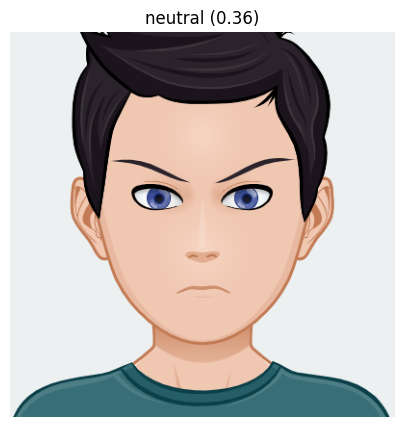

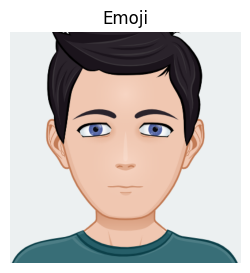

In [7]:
from google.colab import files
uploaded = files.upload()   # 上传一张图片

img_path = list(uploaded.keys())[0]

# ✅ 如果你上传的是 FER2013 那种 48x48 脸图，推荐用 True
predict_emotion_and_show_emoji(img_path, assume_already_face=True)

# ✅ 如果你上传的是普通自拍/照片，改用 False（做人脸检测）
# predict_emotion_and_show_emoji(img_path, assume_already_face=False)
